Helper function to see the distribution of labels

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from tensorflow.keras.datasets import cifar10
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import imdb

In [2]:
def plot_label_distribution(y, title="Label Distribution", xlabel="Labels", ylabel="Frequency"):
    """
    Plots a histogram showing the distribution of labels.

    Parameters:
    y (array-like): Array of labels.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    # Use 'bins' to create a bin for each unique label
    plt.hist(y, bins=np.arange(np.min(y), np.max(y) + 2) - 0.5, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Set x-ticks to be at the center of each bin
    plt.xticks(np.arange(np.min(y), np.max(y) + 1))
    plt.grid(axis='y', alpha=0.75)
    plt.show()

imdb

In [3]:
def load_imbalanced_imdb(num_words=10000, seed=42):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

    # Convert to DataFrame for easier manipulation
    train_df = pd.DataFrame({'review': X_train, 'sentiment': y_train})

    # Create imbalance by removing 90% of negative reviews
    negative_reviews = train_df[train_df['sentiment'] == 0]
    reduced_negative_reviews = negative_reviews.sample(frac=0.1, random_state=seed)
    balanced_positive_reviews = train_df[train_df['sentiment'] == 1]
    imbalanced_train_df = pd.concat([reduced_negative_reviews, balanced_positive_reviews])

    # Split the features and labels
    X_train_imbalanced = imbalanced_train_df['review'].tolist()
    y_train_imbalanced = imbalanced_train_df['sentiment'].tolist()

    return X_train_imbalanced, X_test, y_train_imbalanced, y_test

X_train, X_test, y_train, y_test = load_imbalanced_imdb()

17464789/17464789 [==============================] - 1s 0us/step


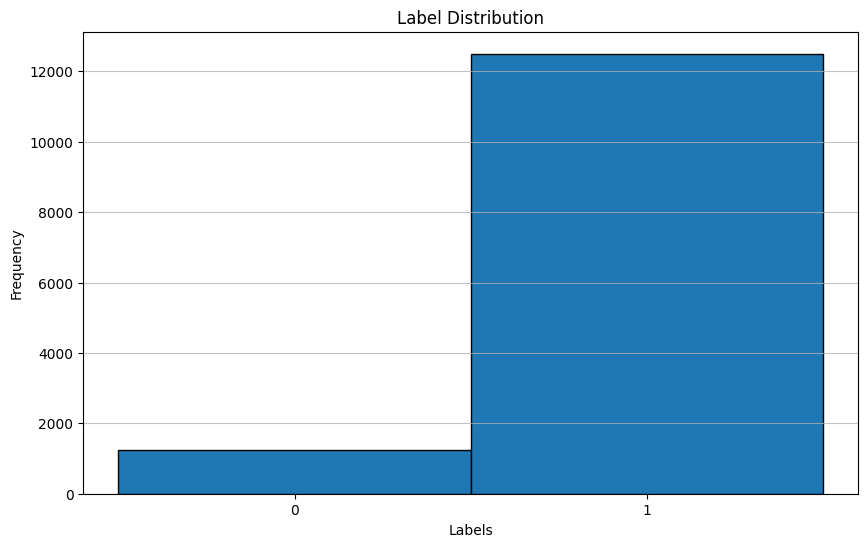

In [4]:
plot_label_distribution(y_train)

CIFAR-10 + imabalce sampling (imbalance_classes)

In [5]:
def imbalance_classes(X, y, imb_type='exp', imb_factor=0.01):
    np.random.seed(42)
    unique_classes = np.unique(y)
    num_classes = len(unique_classes)
    img_max = len(X) / num_classes

    img_num_per_cls = []
    if imb_type == 'exp':
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor**(cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    elif imb_type == 'step':
        for cls_idx in range(num_classes // 2):
            img_num_per_cls.append(int(img_max))
        for cls_idx in range(num_classes // 2):
            img_num_per_cls.append(int(img_max * imb_factor))
    else:
        img_num_per_cls.extend([int(img_max)] * num_classes)

    X_imb, y_imb = [], []
    for cls, img_num in zip(unique_classes, img_num_per_cls):
        idx = np.random.choice(np.where(y == cls)[0], img_num, replace=False)
        X_imb.append(X[idx])
        y_imb.append(y[idx])

    X_imb = np.concatenate(X_imb)
    y_imb = np.concatenate(y_imb)

    return X_imb, y_imb

In [6]:
def load_imbalanced_cifar10(imbalance_type='exp', imbalance_ratio=0.01):
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train_imb, y_train_imb = imbalance_classes(X_train, y_train.flatten(), imbalance_type, imbalance_ratio)
    return X_train_imb, X_test, y_train_imb, y_test.flatten()

In [7]:
X_train_imb, X_test, y_train_imb, y_test = load_imbalanced_cifar10(imbalance_type='exp', imbalance_ratio=0.1)

In [8]:
X_train_imb.shape

(20431, 32, 32, 3)

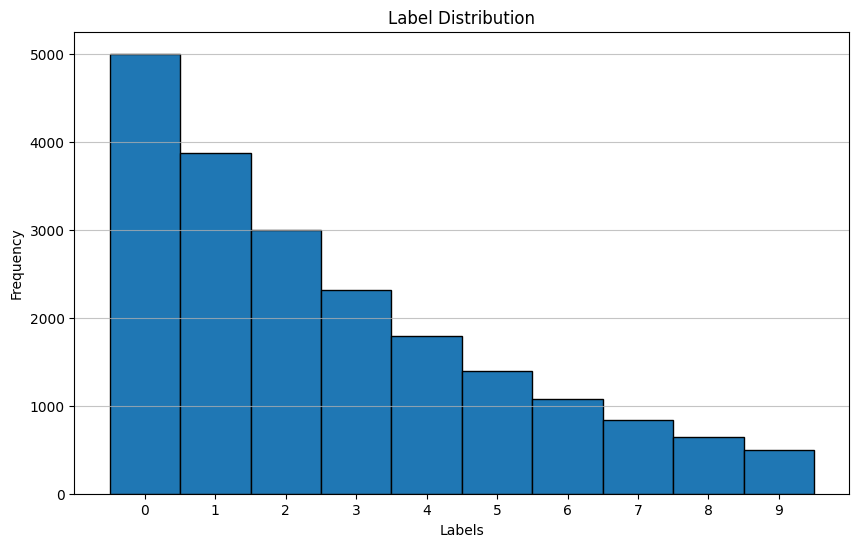

In [9]:
plot_label_distribution(y_train_imb)

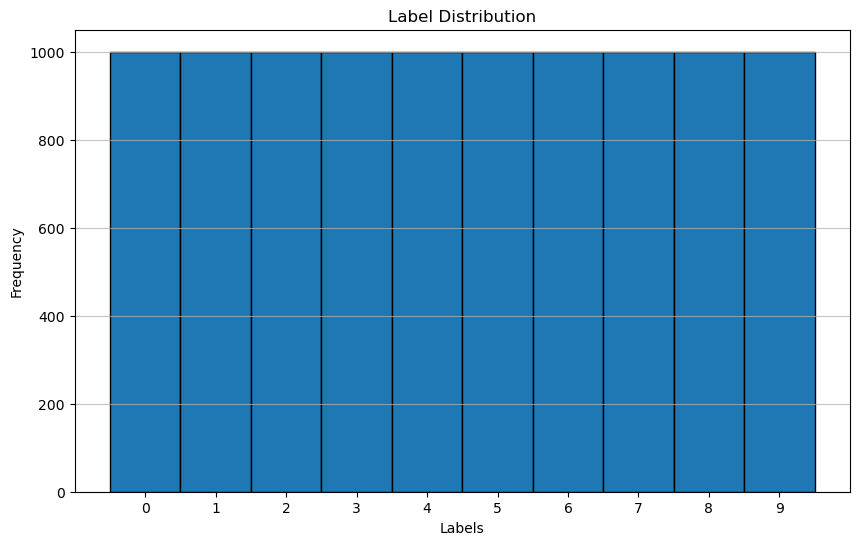

In [22]:
plot_label_distribution(y_test)

CIFAR-100

In [23]:
from tensorflow.keras.datasets import cifar100

In [24]:
def load_imbalanced_cifar100(imbalance_type='exp', imbalance_ratio=0.01):
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    X_train_imb, y_train_imb = imbalance_classes(X_train, y_train.flatten(), imbalance_type, imbalance_ratio)
    return X_train_imb, X_test, y_train_imb, y_test.flatten()

In [25]:
X_train_imb, X_test, y_train_imb, y_test = load_imbalanced_cifar100(imbalance_type='exp', imbalance_ratio=0.1)

169001437/169001437 [==============================] - 55s 0us/step


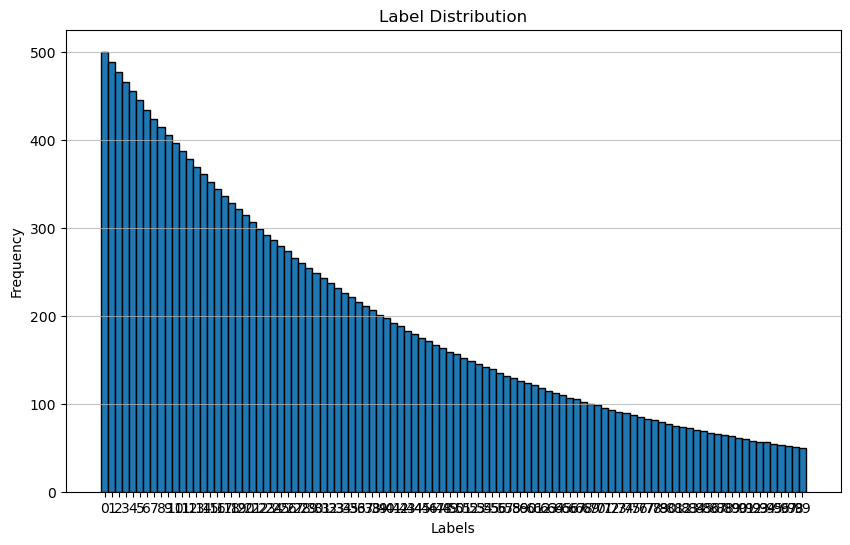

In [26]:
plot_label_distribution(y_train_imb)

Loading a constant number of samples

In [10]:
def clipped_imbalance_classes(X, y, imb_type='exp', imb_factor=0.01, total_samples=1000):
    np.random.seed(42)
    unique_classes = np.unique(y)
    num_classes = len(unique_classes)

    proportions = []
    if imb_type == 'exp':
        total = sum([imb_factor**(i / (num_classes - 1.0)) for i in range(num_classes)])
        proportions = [(imb_factor**(i / (num_classes - 1.0))) / total for i in range(num_classes)]
    elif imb_type == 'step':
        half = num_classes // 2
        total = half + half * imb_factor
        proportions = [1/total] * half + [imb_factor/total] * half
    else:
        proportions = [1/num_classes] * num_classes

    img_num_per_cls = [int(p * total_samples) for p in proportions]

    # Adjust to ensure the total is exactly total_samples
    current_total = sum(img_num_per_cls)
    while current_total != total_samples:
        for i in range(num_classes):
            if current_total < total_samples:
                img_num_per_cls[i] += 1
                current_total += 1
            elif current_total > total_samples:
                img_num_per_cls[i] -= 1
                current_total -= 1
            if current_total == total_samples:
                break

    X_imb, y_imb = [], []
    for cls, img_num in zip(unique_classes, img_num_per_cls):
        idx = np.random.choice(np.where(y == cls)[0], img_num, replace=False)
        X_imb.append(X[idx])
        y_imb.append(y[idx])

    X_imb = np.concatenate(X_imb)
    y_imb = np.concatenate(y_imb)

    return X_imb, y_imb

In [11]:
def load_imbalanced_cifar10(imbalance_type='exp', imbalance_ratio=0.01):
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train_imb, y_train_imb = clipped_imbalance_classes(X_train, y_train.flatten(), imbalance_type, imbalance_ratio)
    return X_train_imb, X_test, y_train_imb, y_test.flatten()

In [15]:
X_train_imb, X_test, y_train_imb, y_test = load_imbalanced_cifar10(imbalance_type='step', imbalance_ratio=0.1)

In [16]:
X_train_imb.shape

(1000, 32, 32, 3)

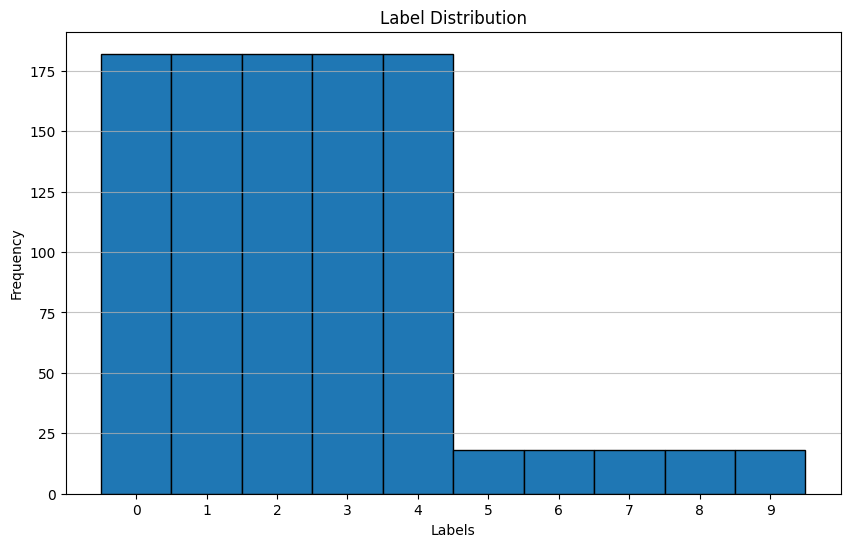

In [17]:
plot_label_distribution(y_train_imb)